# Chapter 4. ESNの最適化

この章では、ESNや学習セットアップに登場するパラメータやハイパーパラメータの調整方法を学び、その計算能力を最大限に引き出す手法を説明します。

## 前書き

前回説明したESNでNARMA10を解くセットアップとそのパラメータを整理しましょう。
一様乱数からサンプルされた入力 $u[k]\sim\mathcal{U}([-1, 1])$ をESNに線形変換で投射し、ESNの状態 $x[k]$ からNARMA10時系列 $y[k]$ を構成するタスクを考えます。
この際、以下のパラメータが登場します。

- $v[k]=\sigma u[k] + \phi$
  - $\sigma \in \mathbb{R}$ : 入力スケール
  - $\phi \in \mathbb{R}$ : バイアス
- $x[k+1] = (1-a)~x[k]+a~\tanh\left(\rho W^\mathrm{rec} x[k] + W^\mathrm{in} v[k+1]\right)$
  - $N \in \mathbb{Z}^+$ : ESNのノード数
  - $\rho \in \mathbb{R}^+$ : スペクトル半径
  - $a \in \mathbb{R}^+$ : 漏れ率 (leaky rate)
  - $x[0]$ : ESNの初期値
- $y[k+1] = \mathrm{NARMA10}(\nu[k],\nu[k-9],~y[k],~\ldots,~y[k-9];\alpha,\beta,\gamma,\delta),~\nu[k] = \mu u[k] + \kappa$
  - $\alpha,\beta,\gamma,\delta \in \mathbb{R}$ : 関数パラメータ
  - $\mu,\kappa\in \mathbb{R}$ : スケーリングパラメータ
- その他
  - $T_\mathrm{washout}\in\mathbb{Z}^+$ : ウォッシュアウトの時間ステップ
  - $T_\mathrm{train}\in\mathbb{Z}^+$ : 学習用データの時間ステップ
  - $T_\mathrm{eval}\in\mathbb{Z}^+$ : 評価用データの時間ステップ

今フェアな比較のため、ターゲットとなるNARMA10のパラメータを典型的なもの $(\alpha,\beta,\gamma,\delta,\mu,\kappa)=(0.3,0.05,1.5,0.1,0.25,0.25)$ に固定し、 $u[k]$ とそれに対応するNARMA10の時系列 $y[k]$ は同じものを使います。
ここでは残りのうち重要なパラメータである、入力スケーリング $(\sigma, \phi)$ 、ESNパラメータ $(N,\rho,a)$ 、そして学習データの長さ $T_\mathrm{train}$ をそれぞれ個別に、もしくはまとめて最適化してみましょう。

## 演習問題と実演

ここからは演習問題とデモンストレーションに移ります。
前回と同じライブラリの他、前回の演習で実装した`ESN`・`Linear`・`narma_func`が`import`により利用できます。
初めに次のセルを実行してください。

なお`ESN`・`Linear`・`narma_func`の内部実装を再確認するには、`import inspect`以下の行をコメントアウトするか`...?? / ??...`を使用してください。

In [ ]:
import itertools
import sys

import numpy as np
import scipy.optimize

if "google.colab" in sys.modules:
    from google.colab import drive  # type: ignore

    if False:  # Set to True if you want to use Google Drive and save your work there.
        drive.mount("/content/gdrive")
        %cd /content/gdrive/My Drive/rc-bootcamp/
        # NOTE: Change it to your own path if you put the zip file elsewhere.
        # e.g., %cd /content/gdrive/My Drive/[PATH_TO_EXTRACT]/rc-bootcamp/
    else:
        pass
        %cd /content/
        !git clone --branch ja https://github.com/rc-bootcamp/rc-bootcamp.git
        %cd /content/rc-bootcamp/
else:
    sys.path.append(".")

from utils.reservoir import ESN, Linear
from utils.style_config import Figure, plt
from utils.task import narma_func
from utils.tester import load_from_chapter_name
from utils.tqdm import tqdm, trange

test_func, show_solution = load_from_chapter_name("04_esn_fine_tuning")

# Uncomment it to see the implementations of `Linear` and `ESN`.
# import inspect
# print(inspect.getsource(Linear))
# print(inspect.getsource(ESN))
# print(inspect.getsource(narma_func))

# Or just use ??.../...?? (uncomment the following lines).
# Linear??
# ESN??
# narma_func??

### 1. 前準備とバッチ処理への拡張

ここからは類似する大量データセットに対して類似の操作を繰り返します。
その前準備として、前回実装した`LRReadout`と`calc_nrmse`を改造し、複数のデータセットに対してまとめて線型回帰とNRMSEの計算が可能になった`BatchLRReadout`と`calc_batch_nrmse`を実装しましょう。
なおこのような一括処理はバッチ処理 (batch processing)と呼ばれ、NumPyではコツさえつかめば比較的容易に実装できます。
また前章で扱われたように、NumPy内部の並列演算によりfor loopを回すよりも効率的な演算が期待できます。

Q1.1.

前回学んだとおり、1列目にバイアス項を加えた予測変数 $\tilde{X}=[1 : X]\in\mathbb{R}^{T\times (N+1)}$ と予測対象変数 $Y\in \mathbb{R}^{T \times D}$ に対して、 $\|Xw - Y\|^2$ を最小化する $\hat{w}\in\mathbb{R}^{(N+1)\times D}$ は下記式により求められる。

$$
\renewcommand{\Rho}{\mathrm{P}}
\begin{align*}
\hat{w} &= (\tilde{X}^\top \tilde{X})^{-1}{\tilde{X}}^\top Y \\
&=\tilde{X}^+ Y
.\end{align*}
$$

しかし[`np.linalg.lstsq`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html)の仕様上、前回実装した`LRReadout`では引数に多次元配列 $\tilde{X}\in\mathbb{R}^{... \times T \times (N+1)},~Y\in \mathbb{R}^{... \times T \times D}$ を与えて、まとめて $\hat{w}^\mathrm{out} \in \mathbb{R}^{...\times (N+1) \times D}$ を得る操作は実現できない。
[`np.linalg.pinv`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html)では多次元配列 $A\in\mathbb{R}^{...\times M \times N}$ の入力が許容され、その返り値として疑似逆行列 $A^+\in\mathbb{R}^{...\times N \times M}$ が得られる。
上記の式と前章の回答を参考にしながら以下の穴埋めを実装し、線型回帰のバッチ処理が可能になった`BatchLRReadout`を完成させよ。

- `BatchLRReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Return(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`

  - Operation(s):
      - `self.weight`の更新
      - `self.bias`の更新

In [ ]:
class BatchLRReadout(Linear):
    def train(self, x: np.ndarray, y: np.ndarray):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        # TODO
        sol = ...
        self.weight = ...
        self.bias = ...
        # end of TODO
        return self.weight, self.bias


def solution(dim_in, dim_out, x_train, y_train, x_eval):
    # DO NOT CHANGE HERE.
    readout = BatchLRReadout(dim_in, dim_out)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "01_01")
# show_solution("01_01", "BatchLRReadout")  # Uncomment it to see the solution.

Q1.2.

同様に長さ $T$ の多次元配列 $Y, \hat{Y}\in\mathbb{R}^{...\times T \times d}$ に対してNRMSEをまとめて計算できる`calc_batch_nrmse`を実装せよ。
ただしNRMSEは以下の式より与えられる。

$$
\begin{align*}
\mathrm{NRMSE}(y, \hat{y}) :&= \dfrac{\mathrm{RMSE}(y, \hat{y})}{\sigma(y)} \\
\mathrm{RMSE}(y, \hat{y}) :&=  \sqrt{\dfrac{\mathrm{RSS}(y, \hat{y}) }{T} }
.\end{align*}
$$

- `calc_batch_nrmse`
  - Argument(s):
    - `y`: `np.ndarray`
      - `shape`: `(..., t, d)`
    - `yhat`: `np.ndarray`
      - `shape`: `(..., t, d)`
  - Return(s):
    - `nrmse`: `np.ndarray`
      - `shape`: `(..., d)`

<details><summary>tips</summary>

- [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)
- [`np.var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html)

</details>

In [ ]:
def calc_batch_nrmse(y, yhat):
    # TODO
    ...


test_func(calc_batch_nrmse, "01_02")
# show_solution("01_02", "calc_batch_nrmse")  # Uncomment it to see the solution.

Q1.3.

$x[k] \in \mathbb{R}^{... T_\mathrm{train}\times N} $に対して、サンプリングならびに線形回帰をまとめて実行しNRMSEを計算する`train_and_eval`を完成させよ。
ただし前章最後に記載した下記のコードを参考にせよ。

```python
x = x_init
xs = np.zeros((t_total, dim_esn))
for idx in range(t_total):
    x = net(x, w_in(us[idx]))
    xs[idx] = x
x_train, y_train = xs[t_washout:-t_eval], ys[t_washout:-t_eval]
x_eval, y_eval = xs[-t_eval:], ys[-t_eval:]
w_out.train(x_train, y_train)
```

- `train_and_eval`
  - Argument(s):
    - `x0`: `np.ndarray`
      - `shape`: `(..., n)`
    - `ys`: `np.ndarray`
      - `shape`: `(...., t_washout + t_train + t_eval, d)`
  - Return(s):
    - `nrmse`: `np.ndarray`
      - `shape`: `(..., d)`
    - `xs`: `np.ndarray`
      - `shape`: `(..., t_washout + t_train + t_eval, n)`

In [ ]:
def create_setup(seed, dim, rho, a=None, f=np.tanh, bound=1.0, bias=0.0, cls=BatchLRReadout):
    rnd = np.random.default_rng(seed)
    w_in = Linear(1, dim, bound=bound, bias=bias, rnd=rnd)
    net = ESN(dim, sr=rho, f=f, a=a, rnd=rnd)
    w_out = cls(dim, 1)
    return w_in, net, w_out


def sample_dataset(
    seed,
    t_washout=1000,
    t_train=2000,
    t_eval=1000,
    narma_parameters=None,
):
    narma_parameters = (
        narma_parameters
        if narma_parameters is not None
        else dict(alpha=0.3, beta=0.05, gamma=1.5, delta=0.1, mu=0.25, kappa=0.25)
    )
    rnd = np.random.default_rng(seed)
    t_total = t_washout + t_train + t_eval
    ts = np.arange(-t_washout, t_train + t_eval)
    us = rnd.uniform(-1, 1, (t_total, 1))
    ys = narma_func(us, np.zeros((10, 1)), **narma_parameters)
    time_info = dict(t_washout=t_washout, t_train=t_train, t_eval=t_eval)
    return ts, us, ys, time_info


def sample_dynamics(x0, w_in, net, ts, vs, display=False):
    assert vs.shape[-2] == ts.shape[0]
    x = x0
    xs = np.zeros((*x.shape[:-1], ts.shape[0], x.shape[-1]))
    for idx in trange(ts.shape[0], display=display):
        x = ...  # TODO Iterate over `ts` to sample the dynamics.
        xs[..., idx, :] = ...  # TODO Store the state `x` at each time step.
    return xs


def eval_nrmse(xs, ys, w_out, time_info, return_out=False, **kwargs):
    t_washout, t_eval = time_info["t_washout"], time_info["t_eval"]
    x_train, y_train = ...  # TODO Specify training range.
    x_eval, y_eval = ...  # TODO Specify evaluation range.
    out = w_out.train(x_train, y_train, **kwargs)
    y_out = w_out(x_eval)
    nrmse = calc_batch_nrmse(y_eval, y_out)
    if return_out:
        return nrmse, *out
    else:
        return nrmse


def train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info, display=False):
    assert vs.shape[-2] == ts.shape[0]
    assert ys.shape[-2] == ts.shape[0]
    xs = sample_dynamics(x0, w_in, net, ts, vs, display=display)
    nrmse = eval_nrmse(xs, ys, w_out, time_info)
    return nrmse, xs


test_func(train_and_eval, "01_03", multiple_output=True)
# show_solution("01_03", "sample_dynamics")  # Uncomment it to see the solution.
# show_solution("01_03", "eval_nrmse")  # Uncomment it to see the solution.

### 2. 入力スケーリング

入力スケーリングのパラメータ $(\sigma, \phi)$ の効果を確認しましょう。

まずこれらのパラメータの機能的意義を説明します。
前述のとおり今 $(\sigma, \phi)$ を用いて入力 $u[k]$ を以下のように変換します。

$$
\begin{align*}
v[k]= \sigma u[k] + \phi
.\end{align*}
$$

$u[k]\sim\mathcal{U}([-1, 1])$ なので $v[k]\sim\mathcal{U}([-\sigma + \phi, \sigma + \phi])$ となります。
分布の範囲より、 $\sigma$ は入力の分散、 $\phi$ は平均を調整します (分散 $\mathrm{Var}[v]=\frac{1}{3}\sigma^2$ 、平均 $\mathrm{E}[v]=\phi$) 。
これらの効果は活性化関数の「形状」との関連で議論できます。
例えば図1に示されるとおり、 $\tanh$ は奇関数 (すなわち $\tanh\left(-y\right)=-\tanh\left(y\right)$ )です。

<div style="text-align: center; width: 750px; margin: auto; background-color: #f8f9fa; padding: 10px; border-radius: 10px;">

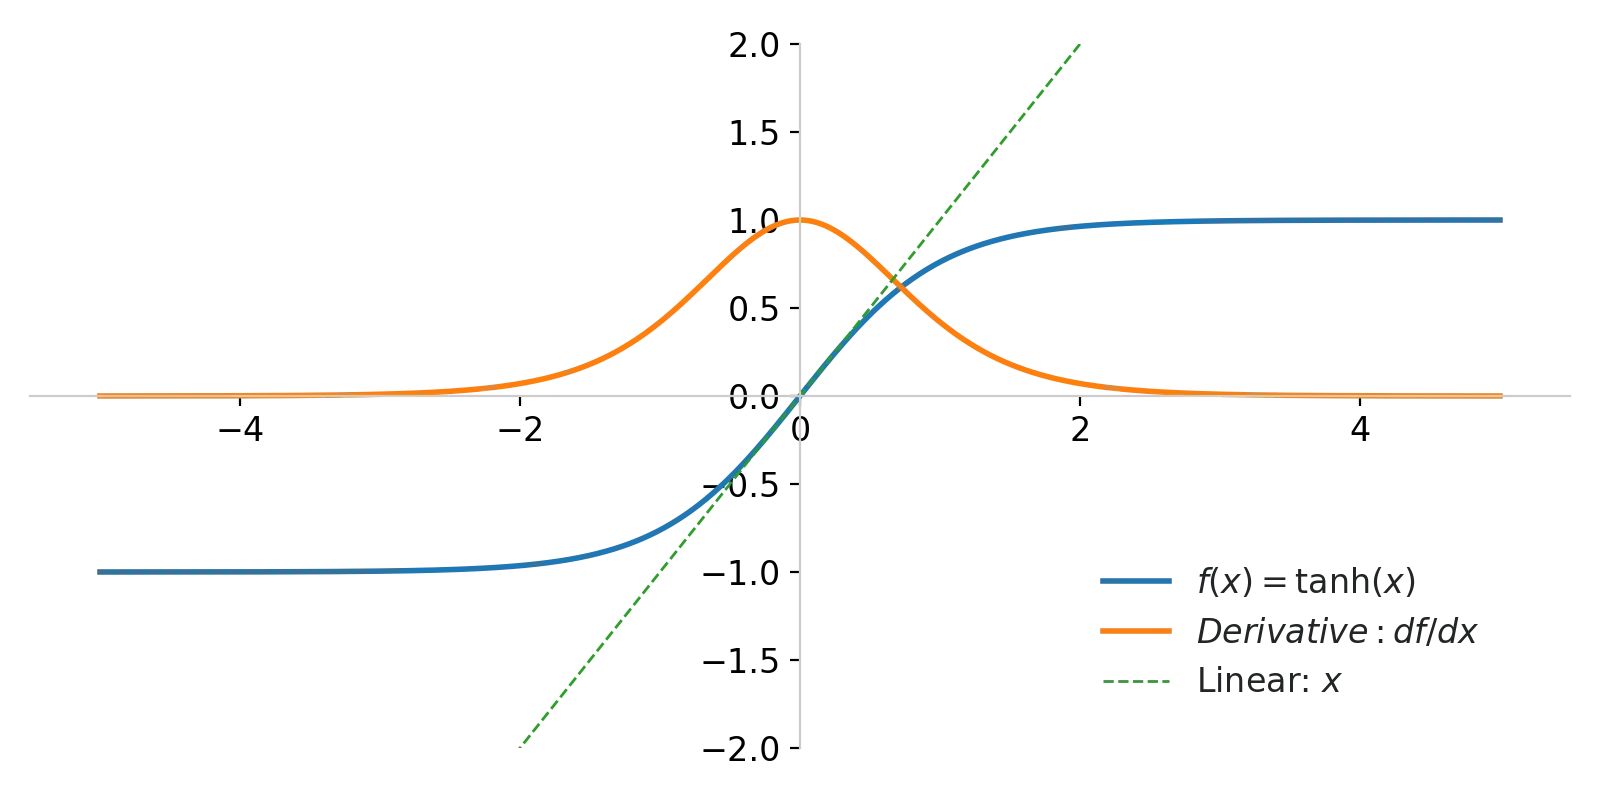
</div>

<figcaption align = "center">

図1 $f(x)=\tanh(x)$ とその導関数 $\dfrac{df}{dx}(x)=1-\tanh^2(x)$ の形状。

</figcaption>

一方で $v[k]$ を展開すると $x[k]$ の時間発展は以下のとおり表現されます。

$$
\begin{align*}
x[k+1] = \tanh\left(\rho W^\mathrm{rec} x[k] + \sigma W^\mathrm{in} u[k+1] + \phi W^\mathrm{in}\right)
.\end{align*}
$$

まず $\phi=0$ に固定して $\sigma$ の特性を考察します。
式と図からわかるとおり $\sigma$ が大きいほど $\tanh$ の「平ら」な範囲に定義域がおよびます。
一方で $\sigma$ が小さいほど $y=x$ に $\tanh$ が近似できる領域に収まります。
このように $\sigma$ はESNの非線形性に大きな影響を与えます。

次に $\phi$ の効果を確認しましょう。
$\phi$ は、後の情報処理能力 (Information Processing Capacity; IPC)の章でより詳細に説明されますが、変換に含まれる成分の次数に影響をあたえます。
今入力が対称 (平均0) であるので、 $x[k]$ を $\{ u[k],~u[k-1].~\ldots\}$ を用いて多項式展開すると、$\phi=0$のケースでは、奇数次数の要素 ( $u^3[\cdot], u^5[\cdot], u[\cdot]u^2[\cdot]$ 等) のみ登場します。
対照的に$\phi\neq 0$の場合、0平均でなくなるので、その要素に偶数次数 ( $u^2[\cdot], u^4[\cdot]$ 等)の要素も加わります。

これらの関数の次数の分布はタスク性能に大きな影響を及ぼします。
例えば今回使うパラメータセットにおけるNARMA10タスクは、解析によりそのほとんどが以下に記される成分で占められると判明しています<sup>[1]</sup>。
- 1次: $u[k-1],~u[k-2],~u[k-3],~u[k-10],~u[k-11],~u[k-12]$
- 2次: $u[k-1]u[k-10],~u[k-2]u[k-11],~u[k-3]u[k-12]$

したがって$\phi=0$と$\phi\neq0$のケースで性能に大きな差が生じます。
以下の演習問題においてここまで確認した$(\sigma, \phi)$の影響を確認しましょう。

Q2.1.

長さ $k$ の配列としてパラメータ $\Sigma = (\sigma_0$, $\sigma_1,~\ldots,~\sigma_{k-1})$ ならびに $\Phi = (\phi_0$, $\phi_1,~\ldots,~\phi_{k-1})$ が与えられる。
各 $(\sigma_i, \phi_i)$ に対するNRMSEをまとめて評価するための $v_i[k] = \sigma_i u[k] + \phi_i$ を出力する関数`convert_us_into_vs`を完成させよ。
ただし与えられる`us`として与えられる $U=\{u[0],~\ldots,~u[k-1]\} \in \mathbb{R}^{T \times 1}$ の`shape` に留意せよ。

- `convert_us_into_vs`
  - Argument(s):
    - `us`: `np.ndarray`
      - `shape`: `(t, 1)`
    - `sigma`: `np.ndarray`
      - `shape`: `(k,)`
    - `phi`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `vs`: `np.ndarray`
      - `shape`: `(k, t, 1)`

In [ ]:
def convert_us_into_vs(us, sigma, phi):
    assert len(sigma) == len(phi)
    vs = ...  # TODO Use broadcasting to convert `us` into `vs`.
    return vs


test_func(convert_us_into_vs, "02_01")
# show_solution("02_01", "convert_us_into_vs")  # Uncomment it to see the solution.

実装した`convert_us_into_vs`を用いて入力が対称なケース ( $v[k]\sim \mathcal{U}([-\sigma, \sigma])$ ) と非対称なケース ( $v[k]\sim \mathcal{U}([0, \sigma])$ )で比較してみましょう。
$\sigma$ が小さいケースで非対称なケースが精度の面で対称入力を上回っています。

In [ ]:
seed_setup, seed_dataset = 1234, 5678  # you can freely change here
dim, rho = 100, 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)


sigmas = np.logspace(-2, 0, 21)  # 10^{-2.0}, 10^{-1.9}, ... 10^{0.0}
x0 = np.zeros((sigmas.shape[0], net.dim))

# Symmetrical case (phi=0).
vs_sym = convert_us_into_vs(us, sigmas, np.zeros_like(sigmas))
nrmse_sym, _xs_sym = train_and_eval(x0, w_in, net, w_out, ts, vs_sym, ys, time_info)
best_sym = np.argmin(nrmse_sym[:, 0])

# Asymmetrical case (phi=sigma).
vs_asym = convert_us_into_vs(us, 0.5 * sigmas, 0.5 * sigmas)
nrmse_asym, _xs_asym = train_and_eval(x0, w_in, net, w_out, ts, vs_asym, ys, time_info)
best_asym = np.argmin(nrmse_asym[:, 0])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(sigmas, nrmse_sym[:, 0], label=r"sym: $[-\sigma, \sigma]$")
ax.plot(sigmas, nrmse_asym[:, 0], label=r"asym: $[0, \sigma]$")
ax.scatter(sigmas[best_sym], nrmse_sym[best_sym, 0], s=100.0, marker="*")
ax.scatter(sigmas[best_asym], nrmse_asym[best_asym, 0], s=100.0, marker="*")
ax.set_xscale("log")
ax.set_xlabel(r"$\sigma$")
ax.set_ylabel(r"NRMSE (best: $\bigstar$)")
ax.legend(frameon=False)

None

Q2.2. (Advanced)

- 他の非線形関数に関しても試してみよ。特に $f$ を偶関数にするとどうなるか実験し、結果を考察せよ。
- $\sigma$ が大きくなると急激に精度が悪化する。$x[k]$ の時系列を描画しながら比較し、その理由を考察せよ。

### 3. ESNパラメータ

次にESN内のパラメータ $(N, \rho, a)$ の役割を確認しましょう。

#### ESNのノード数

まず一般的にリザバーの性能は次元数 $N$ が大きいほど高くなります。
これは、後のIPCの章で議論されますが、IPCの上限がリザバーの次元数 $N$ によって決定されるからです。
また$N$の大きさは**高次元性**と呼ばれリザバーの性能を決定づける重要な特性といえます。

次のセルは $N$ を変化させたときの NRMSEの変化を描画します。

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dims = [10, 20, 50, 100, 200, 500, 1000]
rho = 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = 0.05 * us + 0.05  # vs \in [0.0, 0.1]

nrmses = []
for dim in tqdm(dims):
    x0 = np.zeros(dim)
    w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
    nrmse = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[0])
nrmses = np.asarray(nrmses)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(dims, nrmses, marker=".", markersize=10.0)
ax.set_xscale("log")
ax.set_xlabel("# of ESN nodes")
ax.set_ylabel("NRMSE")

None

より厳密にはリザバーが有するIPCの上限は 階数 $r (\leq N)$ によって決定されます。
これは線形独立な状態時系列の数を表し、一般的に $X$ (定数成分を除外しない場合) または分散共分散行列$C(X):=\mathrm{E}[(X-\mathrm{E}[X])^\top (X-\mathrm{E}[X])]$ (定数成分を除外する場合) の階数 から計算されます。
例えば、以下の次元数 $N=3$ の状態行列 $X=[{x}_0; {x}_1; {x}_2]^{}\in\mathbb{R}^{T\times 3}$を考えます。

$$
\begin{align}
{x}_0 &= [u[0],~u[1],~\ldots,~u[T-1]]^\top, \\
{x}_1 &= [u^2[0],~u^2[1],~\ldots,~u^2[T-1]]^\top, \\
{x}_2 &= [3u^2[0]-4u[0],~3u^2[1]-4u[1],~\ldots,~3u^2[T-1]-4u[T-1]] ^\top
.\end{align}
$$

$x_2=3x_1 - 4x_0$ より $x_2$ は線形従属で $X$ の階数は $2$となります。

```py
In [*]: rnd = np.random.default_rng(1234)
   ...: us = rnd.uniform(-1, 1, (100, 1))
   ...: xs = np.concatenate([us, us**2, 3 * us**2 - 4 * us], axis=1)
   ...: xs_m = xs - xs.mean(axis=0)
   ...: print('rank: {}'.format(np.linalg.matrix_rank(xs_m.T @ xs_m)))
rank: 2
```

線型回帰とその出力 $\hat{Y}$ は、$X$ によって張られる部分空間に対する $Y$ の射影として解釈され、射影行列 $P_X=X X^+$を用いて $\hat{Y}=P_X Y$と表されます。
そしてその部分空間の次元は $X$ の階数 $r$ によって規定されます。
上記の例では線形従属な成分 $x_2$ は部分空間の次元を増やさず、したがって残差誤差 $\|P_X Y - Y \|^2$ の低減には寄与しません。
IPC的な意味では、$x_2$はIPCの増加に寄与しない余分な成分といえます。
このように階数 $r$ は冗長な成分を定量的に評価する重要な指標で、RCの文脈で頻繁に登場します。

階数が最大でないケースは、活性化関数に恒等写像を採用した線形ESNの場合に簡単に構成できます。
以下は線形ESNと $\tanh$ を活性化関数に有する非線形ESNの階数を比較するコードです。

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = np.arange(1, 11) * 10
rho = 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=0)

ts, us, _ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

rank_nlin, rank_lin = [], []
for dim in tqdm(dims):
    x0 = np.zeros(dim)
    t_washout = dataset_info["t_washout"]
    w_in, net, _w_out = create_setup(seed_setup, dim, rho, f=np.tanh)
    # Non-linear case
    xs_nlin = sample_dynamics(x0, w_in, net, ts, vs)[t_washout:]
    xs_nlin -= xs_nlin.mean(axis=0)
    rank_nlin.append(np.linalg.matrix_rank(xs_nlin.T @ xs_nlin))
    # Linear case
    net.f = lambda val: val  # Identity function
    xs_lin = sample_dynamics(x0, w_in, net, ts, vs)[t_washout:]
    xs_lin -= xs_lin.mean(axis=0)
    rank_lin.append(np.linalg.matrix_rank(xs_lin.T @ xs_lin))
rank_nlin = np.asarray(rank_nlin)
rank_lin = np.asarray(rank_lin)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(dims, dims, color="k", label=r"$r=N$")
ax.plot(dims, rank_nlin, marker=".", markersize=10.0, color="red", ls=":", label=r"$f=\tanh$")
ax.plot(
    dims,
    rank_lin,
    marker=".",
    markersize=10.0,
    color="blue",
    ls="--",
    label=r"$f=\mathrm{id}_\mathbb{R}$",
)
ax.set_xlabel("# of ESN nodes")
ax.set_ylabel(r"rank $r$")
ax.legend(frameon=False)

None

Q3.1. (Advanced)

- 線形なケースだと$N$が大きい時に上の例に示されるように階数が最大にならない。この原因を直感的に理解するため、各$N$に対して分散共分散行列 $C(X)$ の固有値 $\{\lambda_i \}_{i=0}^{N-1}$ の絶対値 $|\lambda_{i}|$ を昇順に並べ対数グラフで描画し、線形ESNと非線形ESNを比較せよ。
- 固有値の絶対値の分布を基に考察し、線形ESNでも階数を最大にするための$W^\mathrm{rec}$の上手い初期化の戦略を考察せよ。

#### スペクトル半径

次にスペクトル半径 $\rho$ の影響を調査します。
前章で扱ったように、スペクトル半径 $\rho$ は $W^\mathrm{rec}$ の固有値 $\{\lambda_i \}_{i=0}^{N-1}$ のうち最大の絶対値として以下の式を用いて定義されます。

$$
\begin{align*}
\rho(W^\mathrm{rec}):=\max_{i} |\lambda_{i}|
.\end{align*}
$$

スペクトル「半径」と呼ばれる理由は、前回紹介されたとおり、固有値を複素平面上に並べると視覚的に理解できます。
特に正規分布 $\mathcal{N}\left(0, \frac{1}{N}\right)$ より $W^\mathrm{rec} \in \mathbb{R}^{N\times N}$ の各要素をサンプリングする場合、その固有値は半径1の単円板上におおよそ一様分布する点が知られています (より厳密には複素平面上で半径1の単位円板上の一様測度に $N\to \infty$ でほとんど確実に分布収束)。
またこれは[円則](https://ja.wikipedia.org/wiki/%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E8%A1%8C%E5%88%97#%E5%86%86%E5%89%87)として知られるランダム行列の重要な特性です。

`ESN`では、`normalize=True`によってスペクトル半径 $\rho$ を分離しハイパーパラメータとして扱えます。
まずは様々な $\rho$ に対して一度に $x[t]$ のサンプリングを可能にする`reshape_rho`を以下の設問で実装しましょう。

Q3.2.

長さ$k$ の配列としてスペクトル半径 $\Rho = \left(\rho_0, \rho_1,~\ldots,~\rho_{k-1} \right)$ が与えられる。
同じ入力 $u[k]$ と $W^\mathrm{rec}$ に対してスペクトル半径のみを $\rho_{i}$ に変えたときの $x_{i}[k]$ をまとめてサンプリングできるように、`reshape_rho`を完成させよ。

- `reshape_rho`
  - Argument(s):
    - `rho`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `rho_new`: `np.ndarray`
      - `shape`: `(k, 1)`

In [ ]:
def reshape_rho(rho):
    rho_new = ...  # TODO
    return rho_new


test_func(reshape_rho, "03_02")
# show_solution("03_02", "reshape_rho")  # Uncomment it to see the solution.

スペクトル半径 $\rho$ の効果を直感的に理解するため、$u[k]=0, f=\mathrm{id}_\mathbb{R}$ の無入力線形ESNのケースを考えます。
この際、ESNの時間発展は以下の式で表現されます。

$$
\begin{align*}
x[t+1] = \rho W^\mathrm{rec} x[t]
,\end{align*}
$$

この際、$x[k]$の解析解は以下の式で表されます。

$$
\begin{align*}
x[k] = \rho^k \left({W^\mathrm{rec}}\right)^k x[0]
.\end{align*}
$$

$W^\mathrm{rec}$ は正規化されているため、$\left({W^\mathrm{rec}}\right)^k$ はそのものは発散しません。
一方で $\rho^k$ は $\rho > 1$ の時無限大に発散、$\rho < 1$ の時収束します。
以下のセルは $\rho$ の違いが与える $x[k]$ の応答を図示化します (比較のために $\tanh$ を活性化関数に有する非線形ESNのケースを右側に描画しています)

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dim, rhos = 50, np.array([0.99, 1.0, 1.01])
dataset_info = dict(t_washout=300, t_train=0, t_eval=0)

w_in, net, _w_out = create_setup(seed_setup, dim, reshape_rho(rhos))  # Use `reshape_rho`.
ts, us, _ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = np.zeros_like(us)  # Zero input
x0 = net.rnd.uniform(low=-0.5, high=0.5, size=(1, dim))
x0 = np.broadcast_to(x0, (len(rhos), dim))  # Using the same initial conditions

xs_nlin = sample_dynamics(x0, w_in, net, ts, vs)
net.f = lambda val: val  # Identity function
xs_lin = sample_dynamics(x0, w_in, net, ts, vs)

fig, ax = plt.subplots(len(rhos), 2, figsize=(12, 10), gridspec_kw=dict(hspace=0.05, wspace=0.2))
for idx, rho in enumerate(rhos):
    ax[idx, 0].set_ylabel(r"$\rho = {:.2f}$".format(rho))
    for idy, xs in enumerate([xs_lin, xs_nlin]):
        ax[idx, idy].plot(xs[idx], lw=1.0)
        ax[idx, idy].axhline(1.0, ls="--", color="k", lw=1.0)
        ax[idx, idy].axhline(-1.0, ls="--", color="k", lw=1.0)
        ax[idx, idy].set_yticks([-1.0, 1.0])
        if idx < len(rhos) - 1:
            ax[idx, idy].set_xticklabels([])
ax[-1, 0].set_xlabel("time steps")
ax[-1, 1].set_xlabel("time steps")
ax[0, 0].set_title(r"$f=\mathrm{id}_\mathbb{R}$")
ax[0, 1].set_title(r"$f=\tanh$")

None

まず同じ初期値 $x[k]$ にもかかわらず、 $\rho = 1.01$ で $x[k]$ の値の範囲が $[-1, 1]$ を大きく逸脱しています。
また非線形ESNの場合、 $\rho\geq 1$ でも $x[k]$ は $\tanh$ により $[-1, 1]$ の範囲に収まり無限に発散する状況は発生しませんが、$\rho<1$ のケースのように0に収束しません。
この際、ESPは成立せず、$x[0]$ の影響が残り続けます。
後の章でも扱いますが、$\rho$ を大きくすると非周期的で初期値鋭敏性を有する**カオス**が生じる場合があります。

したがってNARMA10等の通常の用途では $\rho < 1$ に限定して探索される場合が多いです。
再び入力ありのケースを考えましょう。
今簡単のため入力スケール$(\sigma, \phi)=(1, 0)$、$(f, W^\mathrm{rec})=(\mathrm{id}_\mathrm{R}, I) $となる線形ESNを考えます。
この際、状態の時間発展は以下の式で表現されます。

$$
\begin{align*}
x[k+1] = \rho x[k] + W^\mathrm{in} u[k+1]
,\end{align*}
$$

$x[k]$の解析解は以下の式で表現されます。

$$
\begin{align*}
x[k] = W^\mathrm{in} \sum_{j=0}^\infty \rho^{j}  u[k-j]
.\end{align*}
$$

式から推測されるとおり、 $\rho$ は内部状態 $x[k]$ をどれほど保持するか制御するパラメータで $\rho$ が 1に近いほど 過去の入力を保持しやすくなります。
この効果を確かめるため、NARMA10精度の $\rho$ 依存性を調べてみましょう。
次のコードは $\rho$ を0.02刻みで 0から1まで変化させたときの NARMA10タスクの NRMSEと $x[k]$ の階数を描画します。

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = [25, 50, 100]
rhos = np.linspace(0.0, 1.0, 51)[1:-1]  # 0.02, ..., 0.98
rhos_batch = reshape_rho(rhos)  # use `reshape_rhos`.
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

nrmses, best_ids, ranks = [], [], []
for dim in tqdm(dims):
    w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
    x0 = np.zeros((rhos.shape[0], net.dim))
    nrmse, xs = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[:, 0])
    best_ids.append(np.argmin(nrmse[:, 0]))
    xs_m = xs - xs.mean(axis=-2, keepdims=True)
    ranks.append(np.linalg.matrix_rank(xs_m.swapaxes(-2, -1) @ xs_m))

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw=dict(hspace=0.05))
for dim, nrmse, best_id, rank in zip(dims, nrmses, best_ids, ranks, strict=False):
    ax[0].plot(rhos, rank / dim, label=r"$N={}$".format(dim))
    ax[1].plot(rhos, nrmse, label=r"$N={}$".format(dim))
    ax[1].scatter(rhos[best_id], nrmse[best_id], s=100.0, marker="*")
ax[0].set_xticklabels([])
ax[0].set_ylabel(r"$r/N$")
ax[1].set_xlabel(r"$\rho$")
ax[1].set_ylabel(r"NRMSE (best: $\bigstar$)")
ax[1].legend(frameon=False)

None

NARMA10は10次程度の過去入力の成分を有するため、比較的 $\rho$ が $1$ に近く、長く入力情報を保持できる領域が最適であるとわかります。

#### 漏れ率

その他に重要なESNのパラメータとして $a$ が挙げられます。
スペクトル半径 $\rho$ と同様に過去状態をどの程度保持するかを制御するパラメータで $[0, 1]$の範囲の値を取ります。
特に $a=1$ のケースでは線形項のない離散ESNと、 $a=0$ では定数 $x[k]=\mathrm{const.}$ と等価になります。

下記のような連続時間上で定義される連続ESNとその近似の文脈で漏れ率 $a$ はしばしば登場します。

$$
\begin{align*}
\tau \dfrac{dx}{dt}(t) = -x(t) + \tanh\left(\rho W^\mathrm{rec} x(t) + W^\mathrm{in} v(t)\right)
,\end{align*}
$$

ここで $\tau \in \mathbb{R}$ は時定数です。
この式をオイラー法により離散方程式として以下の近似式で表現されます。

$$
\begin{align*}
x(t+\Delta t) = \left(1-\dfrac{\Delta t}{\tau}\right) x(t) + \dfrac{\Delta t}{\tau}\tanh\left(\rho W^\mathrm{rec} x(t) + W^\mathrm{in} v(t + \Delta t)\right)
.\end{align*}
$$

$t := k \Delta t, a=\Delta t / \tau$ により冒頭の式と等価になります。
上記の連続ESNの文脈では $a=0.1$ がよく見られますが、もちろんその限りではありません。
$\rho$ 同様に様々な $a$ に対して一度に $x[k]$ をサンプリングする`reshape_lr`を以下の設問で実装しましょう。

Q3.3.

長さ$k$ の配列として漏れ率 $A = \left(a_0, a_1,~\ldots,~a_{k-1} \right) $ が与えられる。
同じ入力 $u[k]$ と $W^\mathrm{rec}$ に対して漏れ率のみを $a_{i}$ に変えたときのESNの時系列 $x_{i}[k]$ をまとめてサンプリングできるように、`reshape_lr`を完成させよ。

- `reshape_lr`
  - Argument(s):
    - `lr`: `np.ndarray`
      - `shape`: `(k,)`
  - Return(s):
    - `lr_new`: `np.ndarray`
      - `shape`: `(k, 1)`

In [ ]:
def reshape_lr(lr):
    lr_new = ...  # TODO
    return lr_new


test_func(reshape_lr, "03_03")
# show_solution("03_03", "reshape_lr")  # Uncomment it to see the solution.

次のコードは $a$ を $10^{-2}$ から $1$ (離散ESN) まで変化させたときの NARMA10タスクの NRMSEを描画します。
スペクトル半径を $\rho=0.5$ に設定し、内部結合がもたらす記憶特性への寄与を小さくしています。

In [ ]:
seed_setup, seed_dataset = 1234, 5678
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dims = [25, 50, 100]
rho = 0.5
leaky_rates = np.logspace(-1, 0, 21)
lr_batch = reshape_lr(leaky_rates)  # Use `reshape_lr`.
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

nrmses, best_ids = [], []
for dim in tqdm(dims):
    w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh, a=lr_batch)
    x0 = np.zeros((leaky_rates.shape[0], net.dim))
    nrmse, xs = train_and_eval(x0, w_in, net, w_out, ts, vs, ys, time_info)
    nrmses.append(nrmse[:, 0])
    best_ids.append(np.argmin(nrmse[:, 0]))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for dim, nrmse, best_id in zip(dims, nrmses, best_ids, strict=False):
    ax.plot(leaky_rates, nrmse, label=r"$N={}$".format(dim))
    ax.scatter(leaky_rates[best_id], nrmse[best_id], s=100.0, marker="*")
ax.set_xlabel(r"$a$")
ax.set_xscale("log")
ax.set_ylabel(r"NRMSE (best: $\bigstar$)")
ax.legend(frameon=False)
ax.grid(True, which="minor")

None

Q3.4. (Advanced)

- NARMA10よりも時定数の短いタスク (NARMA2)を試し、$\rho$ や $a$ 依存性がどのように変化するか確かめよ。
- オイラー法は[1次のルンゲ・クッタ (Runge-Kutta; RK)法](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods) として一般化される。上記の連続時間上のESNの微分方程式に対して、より高次なRK法 (例えばRK4) を適用し離散化したESNを実装せよ。

### 4. データセットのサイズ

データセットのサイズ $T_\textrm{train}$ の影響を確認しましょう。
一般に学習データの時系列が長いほどより信頼性の高い評価が可能になります。
以下のコードは $(\sigma, \phi, N, \rho) = (0.05, 0.05, 50, 0.9)$ に対して  $T_\textrm{train}= (100,200,400,800,1600,3200)$ と変化させたときのNARMA10のNRMSEの分布 (デフォルトでは100個の $(W^\mathrm{in}, W^\mathrm{rec})$ をランダムに生成) を描画します (完了まで数分程度かかる場合があります。あまりに時間がかかる場合は`sample_num`や`dim`を小さくしてください)。

In [ ]:
sample_num = 100
seed_setup, seed_dataset = 1234, 5678
t_trains = [100, 200, 400, 800, 1600, 3200]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [*bs, 1, N, 1] ([1] -> [*bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([*bs, 1, N] -> [*bs, 1, N])
w_out = BatchLRReadout(dim, 1)

vs = sigma * us + phi
x0 = np.zeros((sample_num, 1, net.dim))
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)
nrmse_dict = {}
for t_train in t_trains:
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info)[:, 0, 0]
    nrmse_dict[t_train] = nrmse
    print("t_train={}: {:.3e}±{:.3e} (#sample={})".format(t_train, nrmse.mean(), nrmse.std(), nrmse.size))

nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict.values()]
nrmse_stds = [nrmse.std() for nrmse in nrmse_dict.values()]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(t_trains, nrmse_aves, nrmse_stds)
ax.set_xlabel(r"$T_\mathrm{train}$")
ax.set_xscale("log")
ax.set_ylabel("NRMSE")
ax.set_yscale("log")
ax.grid(True, which="both")

None

$T_\mathrm{train}$ が小さい時、学習精度が悪くかつその分散が大きく不安定です。
これは最大ランクとなる $N \geq T_\mathrm{train}$ の条件**のみ**では不十分で、より長い時間のサンプルの必要性を示唆しています。
実際 $T_\mathrm{train}$ は $N$ よりずっと大きい値が望ましく、経験的には10倍以上の長さがしばしば採用されます。

Q4.1. (Advanced)

- $N$ を大きくして同様に $T_\mathrm{train}$ とNRMSEの関係を調べよ。
- 他のタスクに関しても同様に調査せよ。

### 5. 時系列の長さが短いときの対処法

> *"I remember my friend Johnny von Neumann used to say, with four parameters I can fit an elephant, and with five I can make him wiggle his trunk."*,
> by [Enrico Fermi, 1953](https://en.wikipedia.org/wiki/Von_Neumann%27s_elephant)
>
> *ジョニーは言っていたよ、『パラメータが4つあったら象だって描けるし、5つあればその鼻さえ動かせる』と。* (エンリコ・フェルミ 1953)

前節では $T_\mathrm{train}$ の大きさの重要性を示しました。
しかしながら現実にはリザバーの次元数 $N$ に対して十分なサイズの学習データを確保できない状況にしばしば遭遇します。
典型的には物理リザバーの研究のように、物性固有の時定数やセンサーのサンプリング周波数によって十分大きな $T_\mathrm{train}$ を確保できない状況が考えられます。
逆にあまりに高次元な設定、すなわち $N$ が大きすぎて要求される $T_\mathrm{train}$ が大きいが、その計算や保存が現実的ではない場合もありえます。

このような状況で注意しなければならないのは **過学習 (overfitting)** と呼ばれる現象の発生です。
すなわち学習データに過適合しすぎて、評価データに対する汎化性能が低い状況を指します。
ここではそのような過学習を避けるテクニックとして **リッジ回帰** (ridge regression) ならびに **赤池情報量規準** (Akaike Information Criteria; AIC) を用いたリッジ回帰のパラメータの自動調整を紹介します。

#### リッジ回帰

リッジ回帰は最小二乗問題におけるコスト関数 $\mathrm{RSS}(X, Y, w):=\|Xw - Y\|^2$ に正則化項を追加して、パラメータ $w$ の大きさ ( $L^2$ ノルム) に制限を加える手法です。
リッジパラメータ $\lambda(>0)$ を用いてそのコスト関数 $\mathcal{L}^\mathrm{ridge}$ は以下の式で定義されます。

$$
\begin{align*}
\mathcal{L}^\mathrm{ridge}(X, Y, w, \lambda) & := \mathrm{RSS}(X, Y, w) + \lambda \|w\|^2
,\end{align*}
$$

ここでこのコスト関数を最小化する $\hat{w}^\mathrm{ridge}$ は以下の式より線形回帰同様にワンショット (one-shot) で求まります。

$$
\begin{align*}
\hat{w}^\mathrm{ridge}(X, Y, \lambda):&=\mathrm{arg}\min_{w} \mathcal{L}^\mathrm{ridge}(X, Y, w, \lambda) \\
&=(X^\top X + \lambda I)^{-1}X^\top Y
.\end{align*}
$$

グラム行列 $X^\top X$ は半正定値行列 (すべての固有値が0以上) なので $X^\top X + \lambda I$ は正定値行列で常に逆行列が存在します。
したがって通常の線型回帰よりもリッジ回帰は数値的に安定といえます。

Q5.1.

`Linear`を継承し、バイアス項を加えた予測変数 $\tilde{X}=[1 : X]\in\mathbb{R}^{...\times T\times (N+1)}$、予測対象変数 $Y\in \mathbb{R}^{... \times T \times D}$ ならびにリッジパラメータ$\lambda \in \mathbb{R}^{+}$ に対して、 $\mathcal{L}^\mathrm{ridge}(\tilde{X}, Y, w)$ を最小化する $\hat{w}^\mathrm{ridge}\in\mathbb{R}^{...\times(N+1)\times D}$ を計算し、その重みとバイアスを更新する `RidgeReadout` を完成させよ。
なお`BatchLRReadout`の実装を参考にせよ。

- `RidgeReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Returns(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`

  - Operation(s):
      - `self.weight`の更新
      - `self.bias`の更新

In [ ]:
class RidgeReadout(Linear):
    def __init__(self, *args, lmbd: float = 0.0, **kwargs):
        super(RidgeReadout, self).__init__(*args, **kwargs)
        self.lmbd = lmbd

    def train(self, x: np.ndarray, y: np.ndarray):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        # TODO Implement ridge regression to obtain `self.weight` and `self.bias`.
        xtx = ...
        xty = ...
        sol = ...
        self.weight = ...
        self.bias = ...
        # end of TODO
        return self.weight, self.bias


def solution(dim_in, dim_out, x_train, y_train, x_eval, lmbd):
    # DO NOT CHANGE HERE.
    readout = RidgeReadout(dim_in, dim_out, lmbd=lmbd)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "05_01")
# show_solution("05_01", "RidgeReadout")  # Uncomment it to see the solution.

次のコードは先程の $T_\mathrm{train}$ を変更するコードで `BatchLRReadout` を `RidgeReadout` に置き換えてNRMSEを描画するコードです。
$\lambda = 0$ の代入でリッジ回帰が線型回帰と等価になる点に注意ください。

In [ ]:
sample_num = 100
seed_setup, seed_dataset = 1234, 5678
t_trains = [50, 100, 200, 400, 800, 1600, 3200]
ridge_parameters = [0.0, 1.0, 1e-2, 1e-4, 1e-6, 1e-8]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [bs, 1, N, 1] (-> [bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([bs, 1, N] -> [bs, 1, N])
w_out = RidgeReadout(dim, 1)  # Use ridge regression.

vs = sigma * us + phi
x0 = np.zeros((sample_num, 1, net.dim))
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)
nrmse_dict = {lmbd: {} for lmbd in ridge_parameters}
for lmbd, t_train in tqdm(list(itertools.product(ridge_parameters, t_trains))):
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    w_out.lmbd = lmbd
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info)[:, 0, 0]
    nrmse_dict[lmbd][t_train] = nrmse
    # print('λ={:.2e}, t_train={}: {:.3e}±{:.3e} (#sample={})'.format(
    #     lmbd, t_train, nrmse.mean(), nrmse.std(), nrmse.size))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for lmbd in ridge_parameters:
    nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict[lmbd].values()]
    nrmse_stds = [nrmse.std() for nrmse in nrmse_dict[lmbd].values()]
    if lmbd == 0.0:
        plot_kws = dict(label=r"LR ($\lambda=0$)", color="k", ls=":")
    else:
        plot_kws = dict(label=r"Ridge ($\lambda=10^{{{:.0f}}}$)".format(np.log10(lmbd)))
    ax.errorbar(t_trains, nrmse_aves, nrmse_stds, **plot_kws)
ax.set_xlabel(r"$T_\mathrm{train}$")
ax.set_ylabel("NRMSE")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="upper right", borderaxespad=0, ncol=1, frameon=False)
ax.grid(True, which="both")

None

特に $T_\mathrm{train} \approx N $ 周辺で 線型回帰が不安定になるのに対し、Ridge ( $\lambda=10^{-4}, 10^{-6}$ )における精度は安定しています。
また $T_\mathrm{train} \gg N$ でも 線型回帰とほぼ同等の精度と安定性を有します。
一方で $\lambda$ が大きい ( $\lambda=10^{0}, 10^{-2}$ ) と精度は安定するものの、線型回帰に大きく劣る結果になっています。
この現象は過学習の対義語で**学習不足 (underfitting)** と呼ばれます。
逆に $\lambda$ を小さくしすぎる ( $\lambda=10^{-8}$ ) と線形回帰同様の不安定性、すなわち過学習が $T_\mathrm{train} \approx N$ で発生します。

このように リッジパラメータ $\lambda$ の適切な選択は、学習の精度や安定性の意味でとても重要です。

#### AICを用いたリッジパラメータ $\lambda$ の自動調整

リッジ回帰ではリッジパラメータの導入により、$T_\mathrm{train}$ が小さいケースでもより安定な学習が可能になりました。
一方で先述のとおり、このリッジパラメータ $\lambda$ はハイパーパラメータの一種であり、その調整が別途必要です。
特に $\lambda$ は任意の正の実数を取りうるので、その探索範囲は無限大におよびその取り扱いはかなり厄介です。
そこでこの $\lambda$ を自動的に決定するためにAICと呼ばれる指標を導入します。
AICはモデルサイズと残差誤差のバランスをとり、妥当なモデルを構築するための指標 (情報量規準) で機械学習の分野で広く使用されます。
リッジ回帰の場合は以下の式で計算されます<sup>[2]</sup>。

$$
\begin{align*}
\mathrm{AIC}(X, Y, \lambda) :&= T \ln\left(\mathrm{RSS}(X, Y, \hat{w}^\mathrm{ridge}(X, Y, \lambda))\right) + \mathrm{df}(X, \lambda) \\
&= T\ln\left(\|X\hat{w}^\mathrm{ridge}(X, Y, \lambda) - Y\|^2\right) + \mathrm{df}(X, \lambda)
,\end{align*}
$$

ここで$\mathrm{df}(X, \lambda)$はモデルの自由度を表し以下の式で計算されます。

$$
\begin{align*}
\mathrm{df}(X, \lambda) :&= \mathrm{tr}[X(X^\top X + \lambda I)^{-1}X^\top] \\
&= \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\sigma_{i}^2+\lambda}
.\end{align*}
$$

$\{\sigma_i \}_{i=0}^{N-1}$ は $X \in \mathbb{R}^{T\times N}$ を特異値分解した際の特異値です。
AICの最小化により妥当な $\lambda$ を選択できます。
一方で式より $0<\mathrm{df} \leq N$ となります。
したがって $\lambda$ の代わりに予め $\mathrm{df}$ の候補 $\{\mathrm{df}_k \}$を用意し、$\mathrm{df}_k = \mathrm{df}(X, \lambda_k)$ となる $\lambda_k$ を逆算し、$\mathrm{AIC}(X, Y, \lambda_k)$ が最小となる $\lambda_k$ を選ぶ指針を取れます。
このような手順で、無限大まで及んだ $\lambda$ の候補を $\mathrm{df}$ の範囲に置き換えて、探索範囲を狭められます。

以下、詳細なアルゴリズムを記載します。

1. $\{\mathrm{df}_k\}$ の候補を作成します。
典型的には整数値 $\{1,~\ldots,~N\}$ のみを候補として選択します。
2. ニュートン法により$f(\lambda_k)=0$の解 $\lambda_k$ を求めます。
3. $\lambda_k$ を用いて $\mathrm{AIC}(X, Y, \lambda_k)$ を計算します。
4. $\mathrm{AIC}(X, Y, \lambda_k)$ を最小化する $k$ ならびに $\lambda_k$ を求めます。

ただし$f(\lambda_k)$は以下の式で定義されます

$$
\begin{align*}
f(\lambda_k) = \mathrm{df}_k - \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\sigma_{i}^2+\lambda_k}
.\end{align*}
$$

またニュートン法では以下の式で与えられる導関数 $\dfrac{df}{d\lambda_k}$ を使用します。

$$
\begin{align*}
\dfrac{df}{d\lambda_k}(\lambda_k) = \sum_{i=0}^{N-1}\frac{\sigma_{i}^2}{\left(\sigma_{i}^2+\lambda_k\right)^2}
.\end{align*}
$$

Q5.2.

上記のアルゴリズムを実装するため、穴埋めを実装し`calc_df_and_lambda`・`calc_aic`・`AutoRidgeReadout`を完成させよ。

- `AutoRidgeReadout.train`
  - Argument(s):
    - `x`: `np.ndarray`
      - `shape`: `(..., time_steps, input_dim)`
    - `y`: `np.ndarray`
      - `shape`: `(..., time_steps, output_dim)`
  - Return(s):
    - `self.weight`: `np.ndarray`
      - `shape`: `(..., output_dim, input_dim)`
    - `self.bias`: `np.ndarray`
      - `shape`: `(..., 1, output_dim)`
    - `*misc`

  - Operation(s):
      - `self.weight`の更新 ( $\mathrm{AIC}$ を最小化する重み )
      - `self.bias`の更新 ( $\mathrm{AIC}$ を最小化するバイアス )
      - `self.lmbd`の更新　( $\mathrm{AIC}$ を最小化する $\lambda$ )

<details><summary>tips</summary>

- [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html)

</details>

In [ ]:
def calc_df_and_lambda(xs: np.array, df_max: int = None, num_cand: int = None, lmbd0=1e-12):
    batch_size, dim = xs.shape[:-2], xs.shape[-1]
    if df_max is None:
        df_max = dim
    if num_cand is None:
        num_cand = df_max

    _left, sigma, _right = np.linalg.svd(xs)
    sigma2 = (sigma**2)[..., None, :]  # [*bs, 1, dim]
    dfs = np.linspace(0, df_max, num_cand + 1)[1:]  # Candidates for degrees of freedom -> [num_cand]
    init_cond = np.full((*batch_size, num_cand), lmbd0)  # Initial condition for λ -> [*bs, num_cand]

    def func(lmbd):
        # TODO `lmbd`: [*bs, num_cand], `sigma2`: [*bs, 1, dim]
        ...

    def fprime(lmbd):
        # TODO `lmbd`: [*bs, num_cand], `sigma2`: [*bs, 1, dim]
        ...

    # TODO Solve f(λ) = 0 for using Newton's method. The output `lmbds` should be of shape [*bs, num_cand].
    lmbds = ...
    # end of TODO
    lmbds[lmbds < 0] = 0  # Remove negative λ due to numerical errors.
    return dfs, lmbds


def calc_aic(xs, ys, **kwargs):
    assert xs.shape[-2] == ys.shape[-2]
    *batch_size, length, dim_in = xs.shape
    dfs, lmbds = calc_df_and_lambda(xs, **kwargs)  # dfs: [num_cand], lmbds: [*bs, num_cand]
    xs = xs[..., None, :, :]  # [*bs, 1, length, dim_in]
    ys = ys[..., None, :, :]  # [*bs, 1, length, dim_in]
    xtx = xs.swapaxes(-2, -1) @ xs  # X^T X: [*bs, 1, dim_in, dim_in]
    xty = xs.swapaxes(-2, -1) @ ys  # X^T Y: [*bs, 1, dim_in, dim_out]
    # TODO Ridge regression with λ -> [*bs, num_cand, dim_in, dim_out]
    sol = ...
    # end of TODO
    rss = ...  # TODO RSS: [*bs, num_cand]
    aics = ...  # TODO AIC: [*bs, num_cand]
    return dfs, lmbds, sol, rss, aics


class AutoRidgeReadout(Linear):
    def __init__(self, *args, lmbd: float = 0.0, **kwargs):
        super(AutoRidgeReadout, self).__init__(*args, **kwargs)
        self.lmbd = lmbd

    def train(self, x: np.ndarray, y: np.ndarray, **kwargs):
        assert (x.ndim > 1) and (x.shape[-1] == self.input_dim)
        assert (y.ndim > 1) and (y.shape[-1] == self.output_dim)
        x_biased = np.ones((*x.shape[:-1], x.shape[-1] + 1), dtype=self.dtype)
        x_biased[..., 1:] = x
        dfs, lmbds, sol, rss, aics = calc_aic(x_biased, y, **kwargs)
        # dfs: [num_cand], lmbds: [*bs, num_cand]
        # sol: [*bs, num_cand, dim_in, dim_out]
        # rss: [*bs, num_cand], aics: [*bs, num_cand]
        best_idx = ...  # TODO Extract the index of the best solution minimizing AIC.
        sol_best = ...  # TODO Choose the best solution minimizing AIC.
        self.lmbd = ...  # TODO Save the best λ minimizing AIC.
        self.weight = ...  # TODO Update weight based on `sol_best`.
        self.bias = ...  # TODO Update bias based on `sol_best`.
        return self.weight, self.bias, dfs, lmbds, sol, rss, aics


def solution(dim_in, dim_out, x_train, y_train, x_eval):
    # DO NOT CHANGE HERE.
    readout = AutoRidgeReadout(dim_in, dim_out)
    readout.train(x_train, y_train)
    return readout(x_eval)


test_func(solution, "05_02")
# show_solution("05_02", "calc_df_and_lambda")  # Uncomment it to see the solution.
# show_solution("05_02", "calc_aic")  # Uncomment it to see the solution.
# show_solution("05_02", "AutoRidgeReadout")  # Uncomment it to see the solution.

$(\sigma,\phi,N,\rho,T_\mathrm{train})=(0.05,0.05,500,0.9,2000)$ のケースで実装した`AutoRidgeReadout`の効果を検証してみましょう (時間の短縮のため`num_cand = dim // 10` により $\{\mathrm{df}_k\}=\{10, 20,~\ldots,~500\}$ としています)。

In [ ]:
seed_setup, seed_dataset = 1234, 5678  # Please choose your favorite seeds.
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 500, 0.9
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs = sigma * us + phi

w_in, net, w_out = create_setup(seed_setup, dim, rho, f=np.tanh, cls=AutoRidgeReadout)

x0 = np.zeros(net.dim)
xs = sample_dynamics(x0, w_in, net, ts, vs, display=True)
nrmse, _weight, _bias, dfs, lmbds, sol, rss, aics = eval_nrmse(
    xs, ys, w_out, time_info, return_out=True, df_max=dim, num_cand=dim // 10
)

best_idx = np.argmin(aics)
rel_aics = aics - aics.min() + 1e0  # Normalize AICs for better visualization.
y_out = w_out(xs)

plot_length = 200
fig = Figure(figsize=(8, 8))
fig.create_grid(2, 1, height_ratios=(2, 1), hspace=0.4)
ax0, ax1 = fig[0], fig[1]
ax0.create_grid(2, 1, wspace=0.4)
ax0[0].plot(dfs, lmbds)
ax0[0].scatter(dfs[best_idx], lmbds[best_idx], s=100.0, marker="*")
ax0[0].set_yscale("log")
ax0[0].set_ylabel(r"$\lambda$")
ax0[0].set_xticklabels([])
ax0[1].plot(dfs, rel_aics)
ax0[1].scatter(dfs[best_idx], rel_aics[best_idx], s=100.0, marker="*")
ax0[1].set_ylabel(r"relative $\mathrm{AIC}$")
ax0[1].set_yscale("log")
info_str = r"best: $\mathrm{{df}}={:.0f},~\lambda=10^{{{:.2f}}}$".format(dfs[best_idx], np.log10(lmbds[best_idx]))
ax0.set_title(info_str)
ax0[1].set_xlabel("df")

ax1.set_xlabel(r"$\mathrm{{df}}$")
ax1.plot(ts[-plot_length:], ys[-plot_length:], color="k", ls=":", lw=1.5)
ax1.plot(ts[-plot_length:], y_out[-plot_length:], lw=1.5, color="red")
ax1.set_title("NRMSE={:.3e}".format(nrmse[0]))
ax1.set_ylabel(r"$y[k]$ & $\hat{y}[k]$")
ax1.set_xlabel("time steps")

None

線型回帰 ( $\lambda=0$ ) やUnderfitting ( $\lambda=10^{-2}$ ) のケースと`AutoRidgeReadout` を比較してみましょう。

In [ ]:
sample_num = 20
seed_setup, seed_dataset = 1234, 5678
t_trains = [100, 200, 400, 800, 1600, 3200]
sigma, phi = 0.05, 0.05  # vs \in [0.0, 0.1]
dim, rho = 50, 0.9
dataset_info = dict(t_washout=100, t_train=max(t_trains), t_eval=1000)
ridge_parameters = [0.0, 1e-2, None]  # None: `AutoRidgeReadout`

ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
w_in_ws, net_ws = [], []
for seed in trange(sample_num):  # Create setups for `sample_num` times.
    w_in, net, _w_out = create_setup(seed_setup + seed, dim, rho, f=np.tanh)
    w_in_ws.append(w_in.weight)
    net_ws.append(net.weight)

w_in_batch = Linear(1, dim)
w_in_batch.weight = np.array(w_in_ws)[:, None, :, :]  # [bs, 1, N, 1] (-> [bs, 1, N])
net_batch = ESN(dim, sr=rho)
net_batch.weight = np.array(net_ws)  # [bs, N, N] ([bs, 1, N] -> [bs, 1, N])
x0 = np.zeros((sample_num, 1, net.dim))
vs = sigma * us + phi
xs = sample_dynamics(x0, w_in_batch, net_batch, ts, vs, display=True)

nrmse_dict = {lmbd: {} for lmbd in ridge_parameters}
lbmd_dict = {lmbd: {} for lmbd in ridge_parameters}
for lmbd, t_train in tqdm(list(itertools.product(ridge_parameters, t_trains))):
    time_info["t_washout"] = dataset_info["t_washout"] + max(t_trains) - t_train
    if lmbd is None:
        w_out = AutoRidgeReadout(dim, 1)
        train_kws = dict(df_max=dim)
    else:
        w_out = RidgeReadout(dim, 1, lmbd=np.array(lmbd))
        train_kws = {}
    nrmse = eval_nrmse(xs, ys, w_out, time_info=time_info, **train_kws)
    nrmse_dict[lmbd][t_train] = np.array(nrmse)
    lbmd_dict[lmbd][t_train] = np.array(w_out.lmbd)
    # print('t_train={}: λ: {:.3e}±{:.3e}, NRMSE: {:.3e}±{:.3e}'.format(
    #     t_train, w_out.lmbd.mean(), w_out.lmbd.std(), nrmse.mean(), nrmse.std()))

fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw=dict(height_ratios=(1, 2), hspace=0.05))
for lmbd in ridge_parameters:
    nrmse_aves = [nrmse.mean() for nrmse in nrmse_dict[lmbd].values()]
    nrmse_stds = [nrmse.std() for nrmse in nrmse_dict[lmbd].values()]
    lmbd_aves = [lmbd.mean() for lmbd in lbmd_dict[lmbd].values()]
    lmbd_stds = [lmbd.std() for lmbd in lbmd_dict[lmbd].values()]
    if lmbd is None:
        plot_kws = dict(label=r"AutoRidge", color="red", ls="--", lw=2.0)
        ax[0].errorbar(t_trains, lmbd_aves, lmbd_stds, **plot_kws)
    elif lmbd == 0.0:
        plot_kws = dict(label=r"LR ($\lambda=0$)", color="k", ls=":")
    else:
        plot_kws = dict(label=r"Ridge ($\lambda=10^{{{:.0f}}}$)".format(np.log10(lmbd)))
    ax[1].errorbar(t_trains, nrmse_aves, nrmse_stds, **plot_kws)
ax[0].set_xscale("log")
ax[0].set_xticklabels([])
ax[0].set_ylabel(r"$\lambda$")
ax[0].grid(True, which="both")
ax[1].set_xlabel(r"$T_\mathrm{train}$")
ax[1].set_ylabel("NRMSE")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].legend(loc="upper right", borderaxespad=0, ncol=1, frameon=False)
ax[1].grid(True, which="both")

None

Q5.3. (Advanced)

- $\sigma$ や $\rho$ を変化させて、`AutoRidgeReadout` のロバスト性を確認せよ。
- 様々な $\lambda$ による精度を `RidgeReadout` によって検証し、 `AutoRidgeReadout`のそれと比較せよ。
- 必ずしも `AutoRidgeReadout`は評価誤差 (NRMSE) を最小にする $\lambda$ を選択できるわけではない。この理由を考察せよ。
- ベイズ情報量規準 (Bayesian Information Criterion; BIC) 等、他にも情報量規準は存在する。これら他の情報規準量を最小化するコードを実装し、AICと比較せよ。

### 6. グリッドサーチ

ここでは複数パラメータをまとめて探索しベストな組み合わせを得る**グリッドサーチ**の方法を学びます。
グリッドサーチでは、予め与えられたハイパーパラメータの候補の**全て**の組み合わせを網羅的に探索されます。
例えば、入力スケールとバイアス、スペクトル半径の3つのパラメータ $(\sigma,\phi,\rho)$ のベストな組み合わせを探索したいとします。
それぞれに関して以下に記される範囲を候補として考えます。

- $\sigma$ : $(0.05,0.10,0.15,~\ldots~,1.00)$
- $\phi$ : $(0.00,0.05,0.10,~\ldots~,1.00)$
- $\rho$ : $(0.6,0.7,0.8,0.9)$

この際、$20\times 21\times 4=840$ 個の組み合わせが考えられ、グリッドサーチではその全てが検証されます。
なおこのグリッドサーチでは先程より登場したバッチ処理が有効です。
ここでもグリッドサーチに向けた、$u[k]$ ならびにESN初期値の指定方法を以下の設問で学びましょう。

Q6.1.

入力時系列 $U=\{u[k]\} \in \mathbb{R}^{T\times 1}$ 、
長さ $k$ の入力スケール配列 $\Sigma = (\sigma_0$, $\sigma_1,~\ldots,~\sigma_{k-1})$ 、
長さ $l$ のバイアスを格納した配列 $\Phi = (\phi_0$, $\phi_1,~\ldots,~\phi_{l-1})$
ならびに 長さ $m$ のスペクトル半径を格納した配列 $\Rho = (\rho_0$, $\rho_1,~\ldots,~\rho_{m-1})$ が与えられる。
同じ $W^\mathrm{in}, W^\mathrm{rec}$ に対して 全部で $k\times l\times m$ 個の条件をまとめて $x[k] \in \mathbb{R}^{k\times l\times m\times N}$ としてサンプリングするために $v[k]$ を生成し $\Rho$ を変形する`create_grid_search_setup` を完成させよ。

- `create_grid_search_setup`
  - Argument(s):
    - `us`: `np.ndarray`
      - `shape`: `(t, 1)`
    - `sigma`: `np.ndarray`
      - `shape`: `(k,)`
    - `phi`: `np.ndarray`
      - `shape`: `(l,)`
    - `rho`: `np.ndarray`
      - `shape`: `(m,)`
  - Return(s):
    - `vs`: `np.ndarray`
      - `shape`: `(k, l, 1, t, 1)`
    - `rho_new`: `np.ndarray`
      - `shape`: `(m, 1)`

In [ ]:
def create_grid_search_setup(us, sigma, phi, rho):
    vs = ...  # TODO
    rho_new = ...  # TODO
    return vs, rho_new


test_func(create_grid_search_setup, "06_01", multiple_output=True)
# show_solution("06_01", "create_grid_search_setup")  # Uncomment it to see the solution.

以下のコードは $840$ 個の組み合わせに対してまとめてNRMSEを評価するコードです (環境によっては描画まで数分かかったり、メモリ不足により実行できないかもしれません。あまりに時間がかかる場合は `dim` や `t_train`を小さくしたり、`sigmas`・`phis`・`rhos`の間隔を大きくしてください)。

In [ ]:
seed_setup, seed_dataset = 1234, 5678
dim = 50
sigmas = np.linspace(0.0, 1.0, 21)[1:]  # [0.05, 0.10, ...., 1.00]
phis = np.linspace(0.0, 1.0, 21)  # [0.0, 0.05,, ...., 1.00]
rhos = np.array([0.6, 0.7, 0.8, 0.9])

dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)
vs_batch, rhos_batch = create_grid_search_setup(us, sigmas, phis, rhos)  # Use `create_grid_search_setup`.

w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
x0 = np.zeros((sigmas.shape[0], phis.shape[0], rhos.shape[0], net.dim))
xs = sample_dynamics(x0, w_in, net, ts, vs_batch, display=True)
nrmse = eval_nrmse(xs, ys, w_out, time_info)[..., 0]  # [k, l, m]

top_num = 5
best_ids = np.array(np.unravel_index(np.argsort(nrmse, axis=None)[:top_num], nrmse.shape)).T
for idx, pos in enumerate(best_ids):
    print(
        "#{}: NRMSE={:.2e}, σ={:.2e}, Φ={:.2e}, ρ={:.2e}".format(
            idx + 1, nrmse[(*pos,)], sigmas[pos[0]], phis[pos[1]], rhos[pos[2]]
        )
    )

grid_num = (len(rhos) ** 0.5).__ceil__()
fig = Figure(figsize=(6 * grid_num, 5 * grid_num))
fig.create_grid(grid_num, grid_num, hspace=0.5, wspace=0.5)

vmax = min(1.0, np.max(nrmse))
vmin = max(0.1, np.min(nrmse))
for idx, rho in enumerate(rhos):
    fig[idx].plot_matrix(
        nrmse[..., idx],
        index=sigmas,
        column=phis,
        vmax=vmax,
        vmin=vmin,
        cmap="viridis",
        zscale="log",
        origin="lower",
    )
    fig[idx].set_xlabel(r"$\phi$")
    fig[idx].set_ylabel(r"$\sigma$")
    fig[idx].set_title(r"$\rho={:.2f}$".format(rho))

px, py, idx = best_ids[0]
fig[idx].scatter(py, px, s=200.0, marker="*", color="magenta")
fig.suptitle(
    r"best NRMSE={:.2e}, $(\sigma,\phi,\rho)=$({:g},{:g},{:g})".format(
        nrmse[(*best_ids[0],)], sigmas[px], phis[py], rhos[idx]
    )
)

None

グリッドサーチは組み合わせの数に比例する計算量が発生します。
したがってハイパーパラメータの数が増えると、計算が現実的でなかったりメモリ不足が発生する場合があります。
一般的にはパラメータを粗く設定した後に、より詳細にパラメータを探索する戦略が取られる場合があります。

様々な方法がありますが、最も簡便な例として以下のアルゴリズムが考えられます。
1. パラメータの分割数 $p$ を決定
2. 最適化するパラメータ $\theta$ の最小値 $\theta_\mathrm{min}$ と最大値 $\theta_\mathrm{max}$ を指定
3. 探索される $p$ 個の パラメータ $\theta_{k} = \theta_\mathrm{min} + (k + 0.5)(\theta_\mathrm{max}-\theta_\mathrm{min})/p~(0 \leq k < p)$ を用意
4. 各 $\theta_k$ に対して目的関数 $\mathcal{L}(\theta_k)$ を計算
5. $\mathcal{L}(\theta_k)$ を最小化する $\hat{k}:=\mathrm{argmin}_k \mathcal{L}(\theta_k)$ を計算
6. $\theta_\mathrm{min}\leftarrow \theta_\mathrm{min}+\hat{k}(\theta_\mathrm{max}-\theta_\mathrm{min})/p$
7. $\theta_\mathrm{max}\leftarrow \theta_\mathrm{min}+(\hat{k}+1)(\theta_\mathrm{max}-\theta_\mathrm{min})/p$
8. 3.に戻る

無論このアルゴリズムは $\mathcal{L}$ の値の変化が パラメータの分割間隔と比して十分に「滑らか」でないと機能しませんが、実装が簡単なので大雑把に良いパラメータの組み合わせを調査するのに使用できます。
次の設問でこのアルゴリズムの重要な箇所を実装しましょう。

Q6.2.

実数  $\theta_\mathrm{min}, \theta_\mathrm{max}$ と分割数を表す正の整数 $p$ が与えられる。
長さ $p$ の配列 $\{\theta_{k}\}$ を生成する`create_parameter_set`を実装せよ。

- `create_parameter_set`
  - Argument(s):
    - `th_min`: `float`
    - `th_max`: `float`
    - `num_split` : `int`
  - Return(s):
    - `th_new`: `np.ndarray`
      - `shape`: `(num_split,)`

In [ ]:
def create_parameter_set(th_min, th_max, num_split):
    th_new = ...  # TODO
    return th_new


test_func(create_parameter_set, "06_02")
# show_solution("06_02", "create_parameter_set")  # Uncomment it to see the solution.

以下のコードは 下記の範囲のパラメータを分割数 5 (`num_split`) で 10回 (`num_iteration`) 繰り返し探索します。

- $\sigma\in (0.0, 1.0)$
- $\phi\in (0.0, 1.0)$
- $\rho\in (0.0, 2.0)$

In [ ]:
num_split = 5
num_iteration = 10
seed_setup, seed_dataset = 1234, 5678
dim = 50
parameter_range = dict(
    sigma=(0.0, 1.0),
    phi=(0.0, 1.0),
    rho=(0.0, 2.0),
)
dataset_info = dict(t_washout=100, t_train=2000, t_eval=1000)
ts, us, ys, time_info = sample_dataset(seed_dataset, **dataset_info)

for idx in range(num_iteration):
    # print(parameter_range)
    sigmas, phis, rhos = map(lambda v: create_parameter_set(*v, num_split), parameter_range.values())
    # print(sigmas, phis, rhos)
    vs_batch, rhos_batch = create_grid_search_setup(us, sigmas, phis, rhos)
    w_in, net, w_out = create_setup(seed_setup, dim, rhos_batch, f=np.tanh)
    x0 = np.zeros((sigmas.shape[0], phis.shape[0], rhos.shape[0], net.dim))
    xs = sample_dynamics(x0, w_in, net, ts, vs_batch, display=False)
    nrmse = eval_nrmse(xs, ys, w_out, time_info)[..., 0]  # [k, l, m]
    best_ids = np.unravel_index(np.argmin(nrmse, axis=None), nrmse.shape)
    print(
        "#{:>2}: NRMSE={:.6e}, σ={:g}, Φ={:g}, ρ={:g}".format(
            idx + 1, nrmse[(*best_ids,)], sigmas[best_ids[0]], phis[best_ids[1]], rhos[best_ids[2]]
        )
    )

    parameter_set_new = dict()
    for pos, (key, param_range) in zip(best_ids, parameter_range.items(), strict=False):
        vmin, vmax = param_range
        vmin_new = vmin + (vmax - vmin) * pos / num_split
        vmax_new = vmin + (vmax - vmin) * (pos + 1) / num_split
        parameter_set_new[key] = (vmin_new, vmax_new)
    parameter_range = parameter_set_new

None

Q6.3. (Advanced)

- $N$ や $p$ を大きくすると環境によってはメモリ不足が発生する場合がある。メモリ不足を回避しながら実行できるようにコードを改変せよ。
- $N$ や $p$ を変化させこのアルゴリズムの長所と短所を考察せよ。
- よりロバストなハイパーパラメータ探索の方法を調査し、実装に組み込め。

Q6.4. (Advanced)

- 今回学んだパラメータの探索方法を活用し、物理リザバーの研究に応用せよ。
- 例えば空気圧人工筋肉 (Pneumatic Artificial Muscle; PAM)<sup>[3, 4]</sup> の研究で公開されているデータセットを用いて、今回のセットアップで検証せよ。

## 参考文献

[1] Kubota, T., Takahashi, H., & Nakajima, K. (2021). *Unifying framework for information processing in stochastically driven dynamical systems*. Physical Review Research, 3(4), 043135. https://doi.org/10.1103/PhysRevResearch.3.043135

[2] Goto, K., Nakajima, K., & Notsu, H. (2021). *Twin vortex computer in fluid flow*. New Journal of Physics, 23(6), 063051. https://doi.org/10.1088/1367-2630/ac024d

[3] Sakurai, R., Nishida, M., Sakurai, H., Wakao, Y., Akashi, N., Kuniyoshi, Y., Minami, Y., & Nakajima, K. (2020). *Emulating a sensor using soft material dynamics: A reservoir computing approach to pneumatic artificial muscle*. 2020 3rd IEEE International Conference on Soft Robotics (RoboSoft), 710–717. https://doi.org/10.1109/RoboSoft48309.2020.9115974

[4] Akashi, N., Yamaguchi, T., Tsunegi, S., Taniguchi, T., Nishida, M., Sakurai, R., Wakao, Y., & Nakajima, K. (2020). *Input-driven bifurcations and information processing capacity in spintronics reservoirs*. Physical Review Research, 2(4), 043303. https://doi.org/10.1103/PhysRevResearch.2.043303